In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, precision_recall_curve, average_precision_score,
confusion_matrix, ConfusionMatrixDisplay, f1_score)
import joblib
import seaborn as sns

In [2]:
path = 'ai4i2020.csv'
df = pd.read_csv(path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [4]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [5]:
# Common binary target in this dataset is 'Machine failure'
if 'Machine failure' in df.columns:
    print('\nValue counts for Machine failure:')
    print(df['Machine failure'].value_counts())


Value counts for Machine failure:
Machine failure
0    9661
1     339
Name: count, dtype: int64


In [6]:
# Failure type flags often present: TWF, HDF, PWF, OSF, RNF
failure_flags = [c for c in ['TWF','HDF','PWF','OSF','RNF'] if c in df.columns]
print('\nDetected failure type flags:', failure_flags)


Detected failure type flags: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [7]:
drop_cols = ['UDI', 'Product ID', 'Product_ID', 'Product id', 'Type'] + failure_flags + (['Machine failure'] if 'Machine failure' in df.columns else [])

In [8]:
# Keep numeric columns and exclude drop_cols
X_all_numeric = df.select_dtypes(include=[np.number])
X = X_all_numeric.drop(columns=[c for c in drop_cols if c in X_all_numeric.columns], errors='ignore')


print('Features selected for Model 1:')
print(list(X.columns))

Features selected for Model 1:
['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [9]:
# target
if 'Machine failure' in df.columns:
    y = df['Machine failure']
else:
    y = None

In [10]:
# Explanation: Split data with stratification to preserve class balance. Scale features for Logistic Regression.

if y is None:
    raise RuntimeError('Binary target "Machine failure" not found in dataset')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train size, Test size:', X_train.shape, X_test.shape)

Train size, Test size: (7500, 5) (2500, 5)


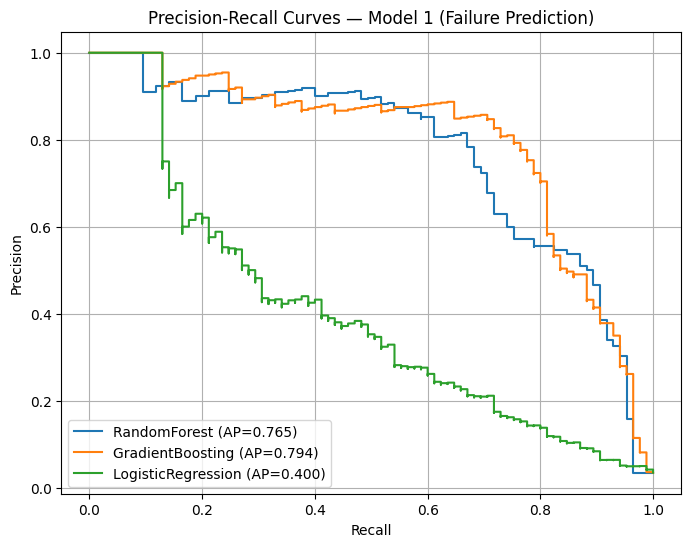

In [11]:
models_m1 = {
'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
'LogisticRegression': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
}


plt.figure(figsize=(8,6))
results_m1 = {}
for name, model in models_m1.items():
    if name == 'LogisticRegression':
        model.fit(X_train_scaled, y_train)
        y_score = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:,1]


    ap = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.step(recall, precision, where='post', label=f"{name} (AP={ap:.3f})")
    
    
    # threshold at 0.5 for classification report
    y_pred = (y_score >= 0.5).astype(int)
    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results_m1[name] = {'ap': ap, 'report': rep, 'model': model}


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves — Model 1 (Failure Prediction)')
plt.legend()
plt.grid(True)
plt.show()

MODEL 1: DETAILED RESULTS


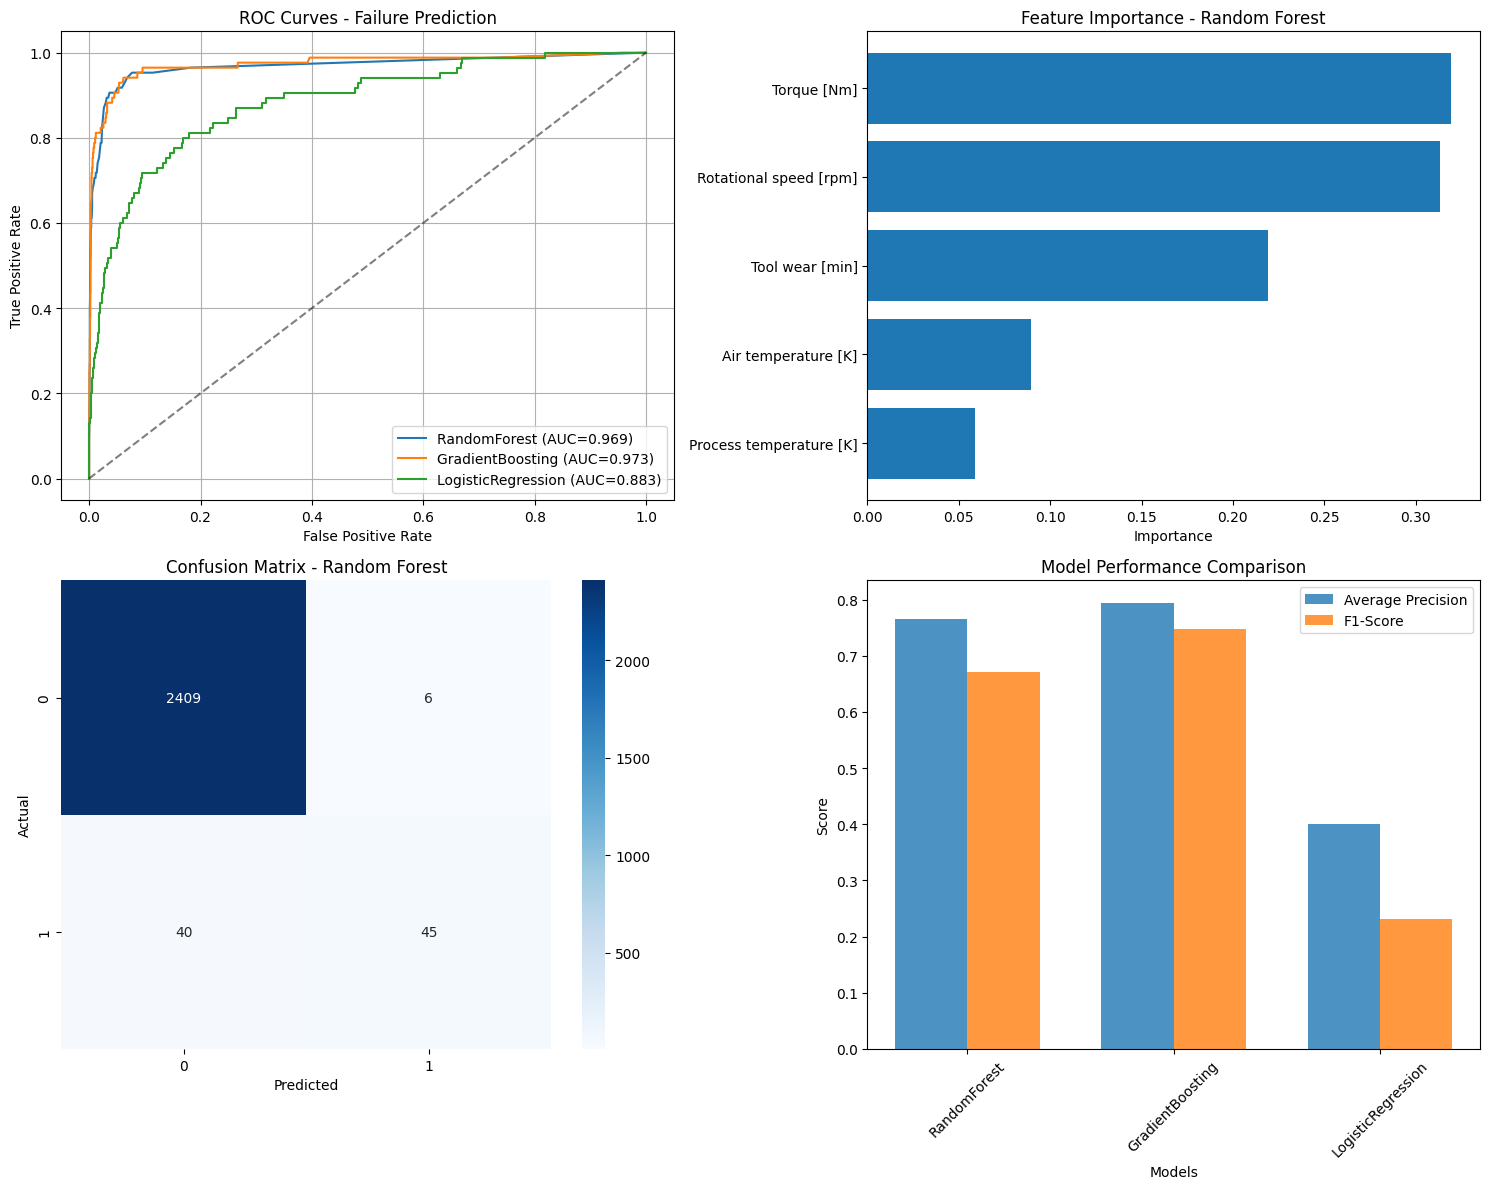


RandomForest Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2415
           1       0.88      0.53      0.66        85

    accuracy                           0.98      2500
   macro avg       0.93      0.76      0.83      2500
weighted avg       0.98      0.98      0.98      2500


GradientBoosting Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2415
           1       0.89      0.65      0.75        85

    accuracy                           0.99      2500
   macro avg       0.94      0.82      0.87      2500
weighted avg       0.98      0.99      0.98      2500


LogisticRegression Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.82      0.90    

In [14]:
# Complete Model 1 results and add ROC curves
from sklearn.metrics import roc_curve, roc_auc_score

# Print detailed results for Model 1
print("="*60)
print("MODEL 1: DETAILED RESULTS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves
ax1 = axes[0, 0]
for name, result in results_m1.items():
    model = result['model']
    if name == 'LogisticRegression':
        y_score = model.predict_proba(X_test_scaled)[:,1]
    else:
        y_score = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Failure Prediction')
ax1.legend()
ax1.grid(True)

# Feature Importance (Random Forest)
rf_model = results_m1['RandomForest']['model']
feature_importance = pd.DataFrame({
    'feature': list(X.columns),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

ax2 = axes[0, 1]
ax2.barh(feature_importance['feature'], feature_importance['importance'])
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance - Random Forest')

# Confusion Matrix for best model
best_model = results_m1['RandomForest']['model']
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

ax3 = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title('Confusion Matrix - Random Forest')

# Performance Comparison
ax4 = axes[1, 1]
model_names = list(results_m1.keys())
ap_scores = [results_m1[name]['ap'] for name in model_names]
f1_scores = [f1_score(y_test, (results_m1[name]['model'].predict_proba(X_test if name != 'LogisticRegression' else X_test_scaled)[:,1] >= 0.5).astype(int)) for name in model_names]

x = np.arange(len(model_names))
width = 0.35

ax4.bar(x - width/2, ap_scores, width, label='Average Precision', alpha=0.8)
ax4.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)

ax4.set_xlabel('Models')
ax4.set_ylabel('Score')
ax4.set_title('Model Performance Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(model_names, rotation=45)
ax4.legend()

plt.tight_layout()
plt.show()

# Print classification reports
for name, result in results_m1.items():
    print(f"\n{name} Classification Report:")
    print("-" * 40)
    if name == 'LogisticRegression':
        y_pred = result['model'].predict(X_test_scaled)
    else:
        y_pred = result['model'].predict(X_test)
    print(classification_report(y_test, y_pred))

In [15]:
# Model 2: Failure Type Classification
print("="*60)
print("MODEL 2: FAILURE TYPE CLASSIFICATION")
print("="*60)

# Create failure type labels
failure_flags = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_type_mapping = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure', 
    'OSF': 'Overstrain Failure',
    'RNF': 'Random Failure'
}

# Get only failed samples
failed_samples = df[df['Machine failure'] == 1].copy()
print(f"Total failed samples: {len(failed_samples)}")

# Create failure type labels
failure_types = []
for idx, row in failed_samples.iterrows():
    for flag in failure_flags:
        if row[flag] == 1:
            failure_types.append(failure_type_mapping[flag])
            break
    else:
        failure_types.append('Unknown')

# Features and targets for Model 2
X_failure_type = failed_samples[['Air temperature [K]', 'Process temperature [K]', 
                                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].copy()
y_failure_type = pd.Series(failure_types)

print(f"Failure type distribution:")
print(y_failure_type.value_counts())
print(f"\nFeatures shape: {X_failure_type.shape}")

MODEL 2: FAILURE TYPE CLASSIFICATION
Total failed samples: 339
Failure type distribution:
Heat Dissipation Failure    115
Power Failure                91
Overstrain Failure           78
Tool Wear Failure            46
Unknown                       9
Name: count, dtype: int64

Features shape: (339, 5)


In [16]:
# Check if we have enough samples for Model 2
if len(X_failure_type) < 10:
    print("Not enough failure samples for reliable failure type classification")
else:
    # Split data for Model 2
    try:
        X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(
            X_failure_type, y_failure_type, test_size=0.3, random_state=42, stratify=y_failure_type
        )
    except ValueError:
        # If stratify fails due to small sample size, don't stratify
        X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(
            X_failure_type, y_failure_type, test_size=0.3, random_state=42
        )
    
    # Scale features for Model 2
    scaler_ft = StandardScaler()
    X_train_ft_scaled = scaler_ft.fit_transform(X_train_ft)
    X_test_ft_scaled = scaler_ft.transform(X_test_ft)
    
    # Define models for failure type classification
    models_m2 = {
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
        'Naive Bayes': GaussianNB()
    }
    
    results_m2 = {}
    
    print("Training Model 2 (Failure Type Classification)...")
    print("-" * 50)
    
    for name, model in models_m2.items():
        print(f"Training {name}...")
        
        if name in ['SVM', 'Naive Bayes']:
            model.fit(X_train_ft_scaled, y_train_ft)
            y_pred = model.predict(X_test_ft_scaled)
        else:
            model.fit(X_train_ft, y_train_ft)
            y_pred = model.predict(X_test_ft)
        
        # Calculate metrics
        f1_macro = f1_score(y_test_ft, y_pred, average='macro')
        f1_weighted = f1_score(y_test_ft, y_pred, average='weighted')
        
        results_m2[name] = {
            'model': model,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'predictions': y_pred
        }
        
        print(f"  F1-Score (Macro): {f1_macro:.4f}")
        print(f"  F1-Score (Weighted): {f1_weighted:.4f}")

Training Model 2 (Failure Type Classification)...
--------------------------------------------------
Training Decision Tree...
  F1-Score (Macro): 0.6561
  F1-Score (Weighted): 0.8069
Training Random Forest...
  F1-Score (Macro): 0.6482
  F1-Score (Weighted): 0.7889
Training SVM...
  F1-Score (Macro): 0.6375
  F1-Score (Weighted): 0.7861
Training Naive Bayes...
  F1-Score (Macro): 0.5990
  F1-Score (Weighted): 0.7402


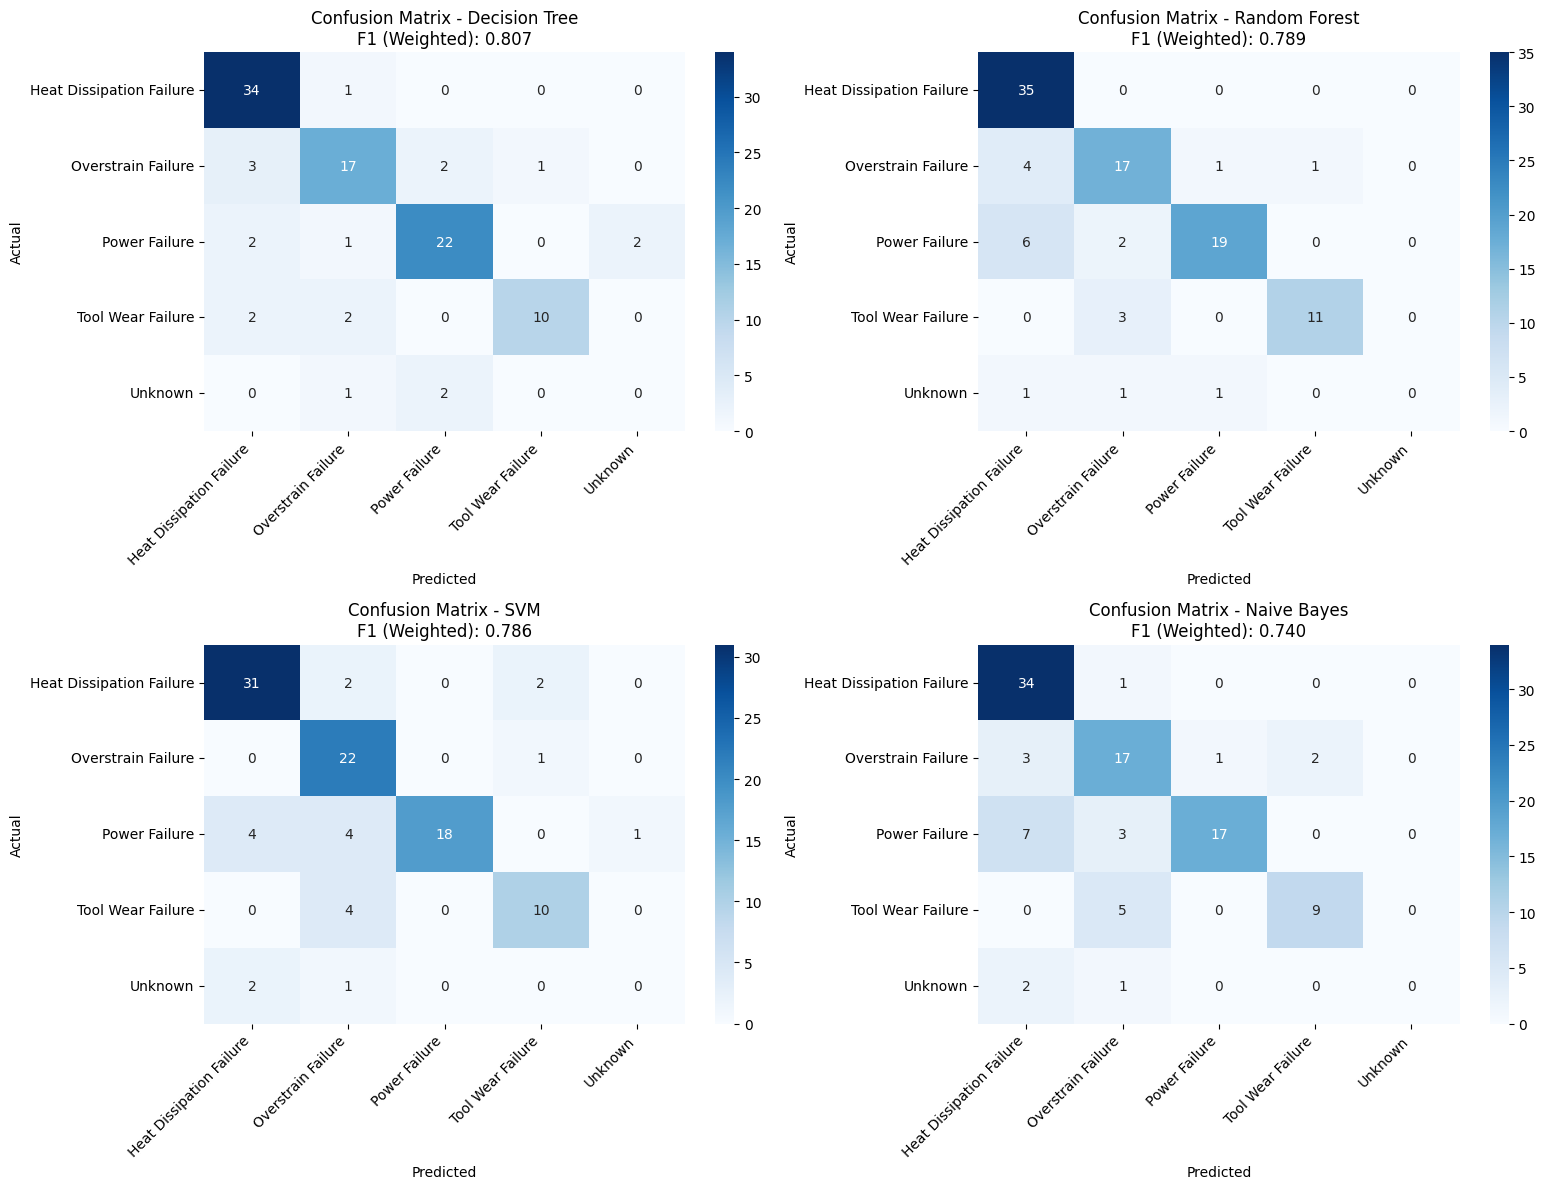

DETAILED CLASSIFICATION REPORTS FOR MODEL 2

Decision Tree Classification Report:
----------------------------------------
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.83      0.97      0.89        35
      Overstrain Failure       0.77      0.74      0.76        23
           Power Failure       0.85      0.81      0.83        27
       Tool Wear Failure       0.91      0.71      0.80        14
                 Unknown       0.00      0.00      0.00         3

                accuracy                           0.81       102
               macro avg       0.67      0.65      0.66       102
            weighted avg       0.81      0.81      0.81       102


Random Forest Classification Report:
----------------------------------------
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.76      1.00      0.86        35
      Overstrain Failure       0.74      0.74      0.74        23
  

In [17]:
if len(X_failure_type) >= 10:
    # Create confusion matrices for all models
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, (name, result) in enumerate(results_m2.items()):
        ax = axes[i//2, i%2]
        
        # Create confusion matrix
        cm = confusion_matrix(y_test_ft, result['predictions'])
        labels = sorted(y_failure_type.unique())
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=labels, yticklabels=labels)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {name}\nF1 (Weighted): {result["f1_weighted"]:.3f}')
        
        # Rotate labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    print("DETAILED CLASSIFICATION REPORTS FOR MODEL 2")
    print("=" * 60)
    
    for name, result in results_m2.items():
        print(f"\n{name} Classification Report:")
        print("-" * 40)
        print(classification_report(y_test_ft, result['predictions'], zero_division=0))

In [18]:
# Compare all models and select best ones
print("="*60)
print("MODEL COMPARISON AND RECOMMENDATIONS")
print("="*60)

# Model 1 comparison
print("\nModel 1 - Failure Prediction Performance:")
print("-" * 40)

failure_comparison = []
for name, result in results_m1.items():
    if name == 'LogisticRegression':
        y_score = result['model'].predict_proba(X_test_scaled)[:,1]
    else:
        y_score = result['model'].predict_proba(X_test)[:,1]
    
    auc_score = roc_auc_score(y_test, y_score)
    f1 = f1_score(y_test, (y_score >= 0.5).astype(int))
    
    failure_comparison.append({
        'Model': name,
        'Average Precision': result['ap'],
        'AUC-ROC': auc_score,
        'F1-Score': f1
    })

failure_df = pd.DataFrame(failure_comparison)
print(failure_df.round(4))

best_failure_model = failure_df.loc[failure_df['F1-Score'].idxmax(), 'Model']
print(f"\nRecommended Model for Failure Prediction: {best_failure_model}")

# Model 2 comparison (if available)
if len(X_failure_type) >= 10:
    print("\nModel 2 - Failure Type Classification Performance:")
    print("-" * 50)
    
    failure_type_comparison = []
    for name, result in results_m2.items():
        failure_type_comparison.append({
            'Model': name,
            'F1-Score (Macro)': result['f1_macro'],
            'F1-Score (Weighted)': result['f1_weighted']
        })
    
    failure_type_df = pd.DataFrame(failure_type_comparison)
    print(failure_type_df.round(4))
    
    best_failure_type_model = failure_type_df.loc[failure_type_df['F1-Score (Weighted)'].idxmax(), 'Model']
    print(f"\nRecommended Model for Failure Type Classification: {best_failure_type_model}")
else:
    print("\nModel 2 - Failure Type Classification:")
    print("Not enough samples for reliable failure type classification")
    best_failure_type_model = None

MODEL COMPARISON AND RECOMMENDATIONS

Model 1 - Failure Prediction Performance:
----------------------------------------
                Model  Average Precision  AUC-ROC  F1-Score
0        RandomForest             0.7651   0.9687    0.6715
1    GradientBoosting             0.7945   0.9731    0.7483
2  LogisticRegression             0.3996   0.8832    0.2321

Recommended Model for Failure Prediction: GradientBoosting

Model 2 - Failure Type Classification Performance:
--------------------------------------------------
           Model  F1-Score (Macro)  F1-Score (Weighted)
0  Decision Tree            0.6561               0.8069
1  Random Forest            0.6482               0.7889
2            SVM            0.6375               0.7861
3    Naive Bayes            0.5990               0.7402

Recommended Model for Failure Type Classification: Decision Tree


In [21]:
# Save the best models for deployment
print("\n" + "="*60)
print("SAVING MODELS FOR DEPLOYMENT")
print("="*60)

# Prepare best failure prediction model
best_failure_model_name = best_failure_model
best_failure_model_obj = results_m1[best_failure_model_name]['model']

# Get scaler if needed
if best_failure_model_name == 'LogisticRegression':
    best_failure_scaler = scaler
else:
    best_failure_scaler = None

# Create model package for failure prediction
failure_model_package = {
    'model': best_failure_model_obj,
    'scaler': best_failure_scaler,
    'model_type': 'failure_prediction',
    'model_name': best_failure_model_name,
    'features': list(X.columns),
    'performance': {
        'average_precision': results_m1[best_failure_model_name]['ap'],
        'auc_roc': roc_auc_score(y_test, best_failure_model_obj.predict_proba(X_test if best_failure_model_name != 'LogisticRegression' else X_test_scaled)[:,1]),
        'f1_score': f1_score(y_test, best_failure_model_obj.predict(X_test if best_failure_model_name != 'LogisticRegression' else X_test_scaled))
    }
}

# Save failure prediction model
joblib.dump(failure_model_package, f'best_failure_prediction_model.pkl')
print(f" Saved failure prediction model: {best_failure_model_name}")
print(f"  - Average Precision: {failure_model_package['performance']['average_precision']:.4f}")
print(f"  - AUC-ROC: {failure_model_package['performance']['auc_roc']:.4f}")
print(f"  - F1-Score: {failure_model_package['performance']['f1_score']:.4f}")

# Save failure type model if available
if len(X_failure_type) >= 10 and best_failure_type_model:
    best_failure_type_model_obj = results_m2[best_failure_type_model]['model']
    
    # Get scaler if needed
    if best_failure_type_model in ['SVM', 'Naive Bayes']:
        best_failure_type_scaler = scaler_ft
    else:
        best_failure_type_scaler = None
    
    failure_type_model_package = {
        'model': best_failure_type_model_obj,
        'scaler': best_failure_type_scaler,
        'model_type': 'failure_type_classification',
        'model_name': best_failure_type_model,
        'features': list(X_failure_type.columns),
        'classes': sorted(y_failure_type.unique()),
        'performance': {
            'f1_macro': results_m2[best_failure_type_model]['f1_macro'],
            'f1_weighted': results_m2[best_failure_type_model]['f1_weighted']
        }
    }
    
    joblib.dump(failure_type_model_package, f'best_failure_type_model.pkl')
    print(f" Saved failure type model: {best_failure_type_model}")
    print(f"  - F1-Score (Macro): {failure_type_model_package['performance']['f1_macro']:.4f}")
    print(f"  - F1-Score (Weighted): {failure_type_model_package['performance']['f1_weighted']:.4f}")

print("\n  Models ready for production deployment!")


SAVING MODELS FOR DEPLOYMENT
 Saved failure prediction model: GradientBoosting
  - Average Precision: 0.7945
  - AUC-ROC: 0.9731
  - F1-Score: 0.7483
 Saved failure type model: Decision Tree
  - F1-Score (Macro): 0.6561
  - F1-Score (Weighted): 0.8069

  Models ready for production deployment!


In [22]:
def predict_maintenance_status(sensor_data, failure_model_path='best_failure_prediction_model.pkl', 
                             failure_type_model_path='best_failure_type_model.pkl'):
    """
    Production-ready function to predict maintenance status from sensor data
    
    Parameters:
    sensor_data: dict with sensor readings
        - 'Air temperature [K]': float
        - 'Process temperature [K]': float  
        - 'Rotational speed [rpm]': int
        - 'Torque [Nm]': float
        - 'Tool wear [min]': int
    
    Returns:
    dict with predictions and recommendations
    """
    
    try:
        # Load failure prediction model
        failure_model_data = joblib.load(failure_model_path)
        failure_model = failure_model_data['model']
        failure_scaler = failure_model_data['scaler']
        feature_cols = failure_model_data['features']
        
        # Prepare input data
        input_data = np.array([[sensor_data[col] for col in feature_cols]])
        
        # Predict failure
        if failure_scaler:
            input_scaled = failure_scaler.transform(input_data)
            failure_prob = failure_model.predict_proba(input_scaled)[0, 1]
            failure_pred = failure_model.predict(input_scaled)[0]
        else:
            failure_prob = failure_model.predict_proba(input_data)[0, 1]
            failure_pred = failure_model.predict(input_data)[0]
        
        result = {
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'failure_prediction': 'FAILURE EXPECTED' if failure_pred == 1 else 'NORMAL OPERATION',
            'failure_probability': round(failure_prob, 4),
            'risk_level': 'HIGH' if failure_prob > 0.7 else 'MEDIUM' if failure_prob > 0.3 else 'LOW',
            'failure_type': None,
            'recommendations': []
        }
        
        # Add recommendations based on risk level
        if failure_prob > 0.7:
            result['recommendations'].extend([
                'IMMEDIATE MAINTENANCE REQUIRED',
                'Stop machine operation',
                'Inspect all components'
            ])
        elif failure_prob > 0.3:
            result['recommendations'].extend([
                'Schedule maintenance soon',
                'Monitor closely',
                'Check high-wear components'
            ])
        else:
            result['recommendations'].append('Continue normal operation')
        
        # Predict failure type if failure is expected
        if failure_pred == 1:
            try:
                failure_type_data = joblib.load(failure_type_model_path)
                failure_type_model = failure_type_data['model']
                failure_type_scaler = failure_type_data['scaler']
                
                if failure_type_scaler:
                    input_scaled = failure_type_scaler.transform(input_data)
                    failure_type_pred = failure_type_model.predict(input_scaled)[0]
                    failure_type_prob = failure_type_model.predict_proba(input_scaled)[0].max()
                else:
                    failure_type_pred = failure_type_model.predict(input_data)[0]
                    failure_type_prob = failure_type_model.predict_proba(input_data)[0].max()
                
                result['failure_type'] = failure_type_pred
                result['failure_type_confidence'] = round(failure_type_prob, 4)
                
                # Add specific recommendations based on failure type
                if 'Tool Wear' in failure_type_pred:
                    result['recommendations'].append('Replace cutting tools')
                elif 'Heat' in failure_type_pred:
                    result['recommendations'].append('Check cooling system')
                elif 'Power' in failure_type_pred:
                    result['recommendations'].append('Inspect power supply and motor')
                elif 'Overstrain' in failure_type_pred:
                    result['recommendations'].append('Reduce operational load')
                    
            except FileNotFoundError:
                result['failure_type'] = 'Classification model not available'
        
        return result
        
    except Exception as e:
        return {
            'error': f'Prediction failed: {str(e)}',
            'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        }

# Test the prediction function
print("="*60)
print("TESTING PRODUCTION PREDICTION FUNCTION")
print("="*60)

# Test with example sensor data
test_sensor_data = {
    'Air temperature [K]': 298.1,
    'Process temperature [K]': 308.6, 
    'Rotational speed [rpm]': 1551,
    'Torque [Nm]': 42.8,
    'Tool wear [min]': 0
}

print("Test sensor reading:")
for key, value in test_sensor_data.items():
    print(f"  {key}: {value}")

print("\nPrediction:")
prediction_result = predict_maintenance_status(test_sensor_data)

for key, value in prediction_result.items():
    if key == 'recommendations':
        print(f"  {key}:")
        for rec in value:
            print(f"    - {rec}")
    else:
        print(f"  {key}: {value}")

TESTING PRODUCTION PREDICTION FUNCTION
Test sensor reading:
  Air temperature [K]: 298.1
  Process temperature [K]: 308.6
  Rotational speed [rpm]: 1551
  Torque [Nm]: 42.8
  Tool wear [min]: 0

Prediction:
  timestamp: 2025-09-25 08:10:08
  failure_prediction: NORMAL OPERATION
  failure_probability: 0.0021
  risk_level: LOW
  failure_type: None
  recommendations:
    - Continue normal operation


C:\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [23]:
print("="*80)
print("PREDICTIVE MAINTENANCE SYSTEM - FINAL SUMMARY")
print("="*80)

print("\n DATASET OVERVIEW:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Failed samples: {df['Machine failure'].sum():,} ({df['Machine failure'].mean()*100:.1f}%)")
print(f"  • Features used: {len(list(X.columns))}")

print("\n MODEL 1 - FAILURE PREDICTION:")
print(f"  • Best model: {best_failure_model}")
print(f"  • Performance: AP={failure_model_package['performance']['average_precision']:.4f}, "
      f"AUC={failure_model_package['performance']['auc_roc']:.4f}, "
      f"F1={failure_model_package['performance']['f1_score']:.4f}")

if len(X_failure_type) >= 10 and best_failure_type_model:
    print(f"\n MODEL 2 - FAILURE TYPE CLASSIFICATION:")
    print(f"  • Best model: {best_failure_type_model}")
    print(f"  • Performance: F1-Macro={failure_type_model_package['performance']['f1_macro']:.4f}, "
          f"F1-Weighted={failure_type_model_package['performance']['f1_weighted']:.4f}")
    print(f"  • Classes: {', '.join(failure_type_model_package['classes'])}")
else:
    print(f"\n MODEL 2 - FAILURE TYPE CLASSIFICATION:")
    print("  • Not enough failure samples for reliable classification")

print(f"\n SAVED FILES:")
print("  • best_failure_prediction_model.pkl")
if len(X_failure_type) >= 10 and best_failure_type_model:
    print("  • best_failure_type_model.pkl")

print(f"\n DEPLOYMENT READY:")
print("  • Use predict_maintenance_status() function for real-time predictions")
print("  • Models can be integrated into production systems")
print("  • Supports both failure prediction and failure type classification")

print(f"\n BUSINESS IMPACT:")
print("  • Reduces unexpected machine downtime")
print("  • Enables proactive maintenance scheduling")
print("  • Provides specific failure type guidance")
print("  • Optimizes maintenance resources")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY! ")
print("="*80)

PREDICTIVE MAINTENANCE SYSTEM - FINAL SUMMARY

 DATASET OVERVIEW:
  • Total samples: 10,000
  • Failed samples: 339 (3.4%)
  • Features used: 5

 MODEL 1 - FAILURE PREDICTION:
  • Best model: GradientBoosting
  • Performance: AP=0.7945, AUC=0.9731, F1=0.7483

 MODEL 2 - FAILURE TYPE CLASSIFICATION:
  • Best model: Decision Tree
  • Performance: F1-Macro=0.6561, F1-Weighted=0.8069
  • Classes: Heat Dissipation Failure, Overstrain Failure, Power Failure, Tool Wear Failure, Unknown

 SAVED FILES:
  • best_failure_prediction_model.pkl
  • best_failure_type_model.pkl

 DEPLOYMENT READY:
  • Use predict_maintenance_status() function for real-time predictions
  • Models can be integrated into production systems
  • Supports both failure prediction and failure type classification

 BUSINESS IMPACT:
  • Reduces unexpected machine downtime
  • Enables proactive maintenance scheduling
  • Provides specific failure type guidance
  • Optimizes maintenance resources

PROJECT COMPLETED SUCCESSFULLY! 